In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None # default warn => SettingWithCopyWarning
import numpy as np
#import matplotlib.pyplot as plt
#from collections import namedtuple
#from pprint import (pprint as pp, pformat as pf)
#import time
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
from IPython.display import HTML, display
from ipywidgets import AppLayout, Button, Layout, VBox, HBox, Label, HTML, interact
import ipywidgets as widgets
import arrow

import dmyplant2
dmyplant2.cred()
mp = dmyplant2.MyPlant(3600)
from dmyplant2 import msgFSM, FSMPlot_Start, bokeh_show

In [2]:
def sfun(x):
    return all([
            ("Forsa Hartmoor" in str(x['IB Site Name'])), 
            (x['OperationalCondition'] != 'Decommissioned')
        ])

In [3]:
fleet = mp.search_installed_fleet(sfun).drop('index', axis=1)
fleet = fleet.sort_values(by = "Engine ID",ascending=True).reset_index(drop='index')
pname = 'persist.json'
try:
    persist_dialog = dmyplant2.load_json(pname)
except FileNotFoundError:        
    persist_dialog = {
        'dl': 0,
        'modes': [
                {'name':'???','value':False },
                {'name':'OFF','value':False },
                {'name':'MANUAL','value':False},
                {'name':'AUTO','value':True }],
        'starts': [   
                {'name':'True','value':True },
                {'name':'False','value':False }]   
    }
    dmyplant2.save_json(pname,persist_dialog)

In [4]:
    fleet.T

,0,1,2,3,4,5,6,7,8,9,10
Count_OpHour,213.0,212.0,201.0,193.0,207.0,213.0,199.0,183.0,186.0,149.0,185.0
OperationalCondition,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available,Available
shutdown_counter,150.0,118.0,111.0,111.0,112.0,110.0,104.0,97.0,104.0,95.0,106.0
startup_counter,150.0,117.0,112.0,112.0,112.0,109.0,105.0,98.0,105.0,94.0,102.0
id,159396,159397,159399,159398,159400,159401,159403,159402,159404,159405,159406
Engine Version,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12,H12
Engine Type,624,624,624,624,624,624,624,624,624,624,624
Engine Series,6,6,6,6,6,6,6,6,6,6,6
Country,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB,GB
Commissioning Date,2022-01-10,2022-01-10,2022-01-11,2022-01-11,2022-01-22,2022-01-10,2022-01-11,2022-01-11,2022-01-11,2022-01-22,2022-01-11


In [5]:
# Dialog
persist_dialog = dmyplant2.load_json(pname)
ddl = pd.DataFrame(fleet['serialNumber'] + ' - ' + fleet['IB Site Name'] + ' ' + fleet['Engine ID'])[0].to_list()
ddl = [(m, i) for i, m in enumerate(ddl)]
#dl=widgets.Dropdown(options = ddl,value=0,description='Engine:',layout={'width':'max-content'},disabled=False)
dl=widgets.Dropdown(options = ddl,value=persist_dialog['dl'],description='Engine:',layout={'width':'auto'},disabled=False)
out = widgets.Output(layout={'height':'auto', 'width':'auto'})
rmodes = persist_dialog['modes']
service_selector_modes = [] 
modes = []
for mm in rmodes:
    service_selector_modes.append(widgets.Checkbox(
        value=mm['value'], 
        description=mm['name'],
        layout={'width':'auto'},
        disabled=False,indent=False))

rsucc = persist_dialog['starts']
successful_starts = []; 
for rs in rsucc:
    successful_starts.append(widgets.Checkbox(
            value=(str(rs['value']) == rs['name']),
            description=rs['name'],
            layout={'width':'auto'},
            disabled=False,indent=False))

app = AppLayout(  header=dl,
            #left_sidebar=Button(description='center', button_style='warning', layout=Layout(height='auto', width='auto')),
            left_sidebar=None,
            center=HBox([
                VBox(service_selector_modes),
                VBox(successful_starts),
                out
            ]),
            right_sidebar=None,
            footer = None,
            #footer = Button(description='footer', button_style='success', layout=Layout(height='auto', width='auto')),
            pane_widths=['10px',1,'10px'],
            pane_heights=['40px','250px','40px']
            )
display(app)

AppLayout(children=(Dropdown(description='Engine:', layout=Layout(grid_area='header', width='auto'), options=(…

In [6]:
# Load Engine Data and execute FSM Run 1 - display Results 
persist_dialog = {
    'dl':dl.value, 
    'modes': [{'name':cb.description, 'value':cb.value} for cb in service_selector_modes],
    'starts': [{'name':cb.description, 'value': str(cb.value) == cb.description} for cb in successful_starts]}
dmyplant2.save_json(pname,persist_dialog)
e=dmyplant2.Engine.from_fleet(mp,motor:=fleet.iloc[dl.value])
fsm = msgFSM(e, p_from=e['Commissioning Date'], p_to=arrow.now(), frompickle=True)
fsm.run1(enforce=False) # run Finite State Machine
fsm.store()

In [7]:
out.clear_output()
with out:
    fsm.summary_out()
rdf = fsm.result
#rdf[fsm.filters['filter_content']].round(2)
modes = [rmodes[i]['name'] for i,v in enumerate(service_selector_modes) if v.value]
success = [rsucc[i]['value'] for i,v in enumerate(successful_starts) if v.value]
rda = rdf[:].reset_index(drop='index')
rda['count_alarms'] = rda.apply(lambda x: len(x['alarms']), axis=1)
rda['count_warnings'] = rda.apply(lambda x: len(x['warnings']), axis=1)
rda = rda[(rda['mode'].isin(modes) & rda['success'].isin(success))]
display(HTML(pd.DataFrame.from_dict(e.dash, orient='index').T.to_html(escape=False, index=False)))
print(modes, success)
#rda[fsm.filters['filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

HTML(value='<table border="1" class="dataframe">\n  <thead>\n    <tr style="text-align: right;">\n      <th>Na…

['???', 'OFF', 'MANUAL', 'AUTO'] [True, False]


In [8]:
# Execute FSM Run 2
rda = fsm.run2(rda)
fsm.store()

FSM Run2: 100%|███████████████████████| 127/127 [00:00<00:00, 10545.55 starts/s]


In [9]:
rdb = rda
#rdb = rda[(rda['mode'].isin(['AUTO','MANUAL'])) & ((rda['count_alarms'] > 0) | (rda['count_warnings'] > 0))]
#rdb = rda[rda['synchronize'] < 15.0]
rdb[fsm.filters['run2filter_content'] + fsm.filters['filter_alarms_and_warnings']].round(2)

,index,success,mode,startpreparation,starter,hochlauf,idle,synchronize,loadramp,cumstarttime,maxload,ramprate,targetoperation,coolrun,count_alarms,count_warnings
0,0,False,???,102.47,4.24,22.68,61.00,NaN,NaN,190.39,0.00,NaN,NaT,NaN,0,0
1,1,True,???,93.11,4.14,20.57,6.25,54.96,126.92,305.95,4487.23,0.79,0 days 00:14:26,60.64,0,0
2,2,True,???,0.61,4.04,18.18,4.34,45.72,167.87,240.75,4494.00,0.60,0 days 00:54:47,60.42,0,1
3,3,True,???,60.61,3.64,18.90,5.56,48.25,130.37,267.33,4513.00,0.77,0 days 04:05:15,60.52,0,0
4,4,True,???,96.44,4.13,20.02,5.77,45.56,129.87,301.79,4504.94,0.77,0 days 00:51:40,60.47,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122,122,True,AUTO,102.09,3.84,22.61,4.64,2.01,144.09,279.28,4511.39,0.70,0 days 02:02:32,60.84,0,0
123,123,True,AUTO,97.74,3.83,19.90,4.44,62.37,91.52,279.81,4509.26,1.10,0 days 03:32:28,60.72,0,0
124,124,False,AUTO,101.98,3.63,23.00,4.54,61.97,32.38,227.51,2006.46,1.38,NaT,NaN,1,1
125,125,True,AUTO,93.00,3.84,20.83,4.44,43.75,112.29,278.15,4497.86,0.89,0 days 00:04:00,60.52,0,0


,startpreparation,hochlauf,idle,synchronize,loadramp,maxload,ramprate,cumstarttime,coolrun
count,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00,81.00
mean,104.21,20.62,5.92,26.39,162.71,4409.05,0.80,323.78,60.58
std,46.71,2.71,6.05,21.82,317.79,443.69,0.23,324.80,0.69
min,0.61,8.06,4.03,1.00,45.21,1807.28,0.03,200.33,56.88
25%,93.11,18.57,4.44,5.05,112.29,4492.00,0.69,277.77,60.45
50%,99.79,20.39,4.74,19.62,128.98,4499.32,0.77,279.20,60.56
75%,103.33,22.72,5.64,45.56,144.11,4509.26,0.79,280.96,60.85
max,311.66,27.04,46.65,64.56,2976.27,4535.96,2.05,3179.24,61.88


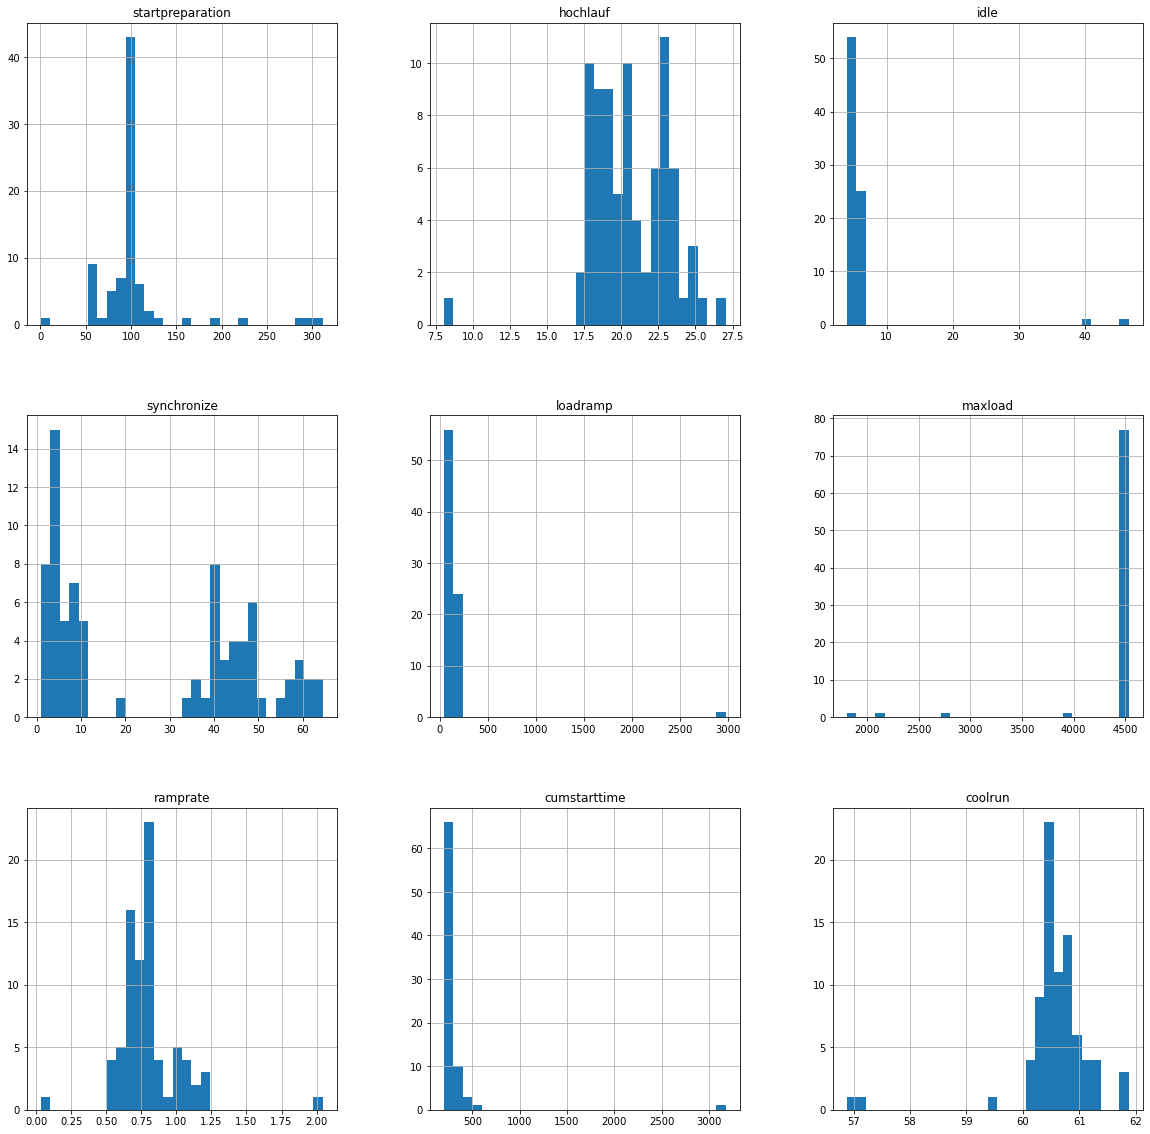

In [10]:
display(_=rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','coolrun']].dropna().hist(bins=30,figsize=(20,20)))
display(rdb[['startpreparation','hochlauf','idle','synchronize','loadramp','maxload','ramprate','cumstarttime','coolrun']].dropna().describe().round(2))

In [11]:
vset = fsm._data_spec + ['Hyd_PressCrankCase','Hyd_PressOilDif','Hyd_PressOil','Hyd_TempOil']
dset = [
    {'col':['Power_PowerAct'], 'ylim':(0,5000), 'color':'red'},
    {'col':['Various_Values_SpeedAct'],'ylim': [0, 2500], 'color':'blue'},
    {'col':['Hyd_PressCrankCase'],'ylim': [-100, 100], 'color':'orange'},
    {'col':['Hyd_PressOilDif'],'ylim': [0, 2], 'color':'black'},
    {'col':['Hyd_PressOil'],'ylim': [0, 10], 'color':'brown'},
    {'col':['Hyd_TempOil'],'ylim': [0, 110], 'color':'#2171b5'}
]

In [12]:
@interact(x = (0, rdb.shape[0]-1))
def f(x=0):
    global v
    v = x
    startversuch = rdb.iloc[x]
    ftitle = f"{fsm._e} ----- Start {startversuch['index']} {startversuch['mode']} | {'SUCCESS' if startversuch['success'] else 'FAILED'} | {startversuch['starttime'].round('S')}"
    print(ftitle)
    fsm.disp_result(startversuch)

interactive(children=(IntSlider(value=0, description='x', max=126), Output()), _dom_classes=('widget-interact'…

In [13]:
FSMPlot_Start(fsm,rdb.iloc[v], vset, dset)

von: 17.01.2022 11:43:06 bis: 17.01.2022 12:33:12


In [14]:
rde = rda[(rda.starttime > fsm._e['Commissioning Date']) & (rda['success']) & (rda['maxload'] > 4000.0)]
dset = [
    {'col':['cumstarttime'],'ylim':(-400,900), 'color':'darkblue'},
    {'col':['synchronize'],'ylim':(-50,650)},
    {'col':['startpreparation'],'ylim':(-600,300)},
    {'col':['hochlauf'],'ylim':(-100,200), 'color':'black'},
    {'col':['loadramp'],'ylim':(-150,900), 'color':'red'},
    {'col':['ramprate'],'ylim':(-3,3)},
    {'col':['maxload'],'ylim':(500,5000) }
]
ftitle = f"{fsm._e}"
fig = dmyplant2.dbokeh_chart(rde, dset, x='starttime', figsize=(16,10) ,title=ftitle);
bokeh_show(fig)

In [15]:
nalarms = []
ct = 0
ct2 = 0
mini = 0
maxi = 100
for i,c in rdf.iterrows():
    if len(c['alarms']) > 0 and not c['success']:
        ct += 1
        print(f"\nStartversuch: {i}, Success: {c['success']}")
        for a in c['alarms']:
            nalarms.append(a['msg'])
            _txt = f"{ct2} {c['mode']:15} {a['state']:20} {a['msg']['timestamp']} {pd.to_datetime(int(a['msg']['timestamp'])*1e6).strftime('%d.%m.%Y %H:%M:%S')} {a['msg']['name']} {a['msg']['message']}"
            print(_txt)
            #if ct2 >= mini and ct2 <= maxi:
                #fsm.plot_cycle(c, ylim=(0,2500), cycletime=1, marker=None,figsize=(20,12), title=f"{i:3d} - {fsm._e} {_txt}")
                #plt.show()
            ct2 += 1
print(f"""
***********************************
** {ct:3} not successful starts  **
***********************************"""
)



Startversuch: 124, Success: False
0 AUTO            loadramp             1646476736246 05.03.2022 10:38:56 1105 Rate of charge temperature change maximum

***********************************
**   1 not successful starts  **
***********************************


In [16]:
al = pd.DataFrame(fsm._pareto(nalarms))
if not al.empty:
    al.sort_values(by = "anz",ascending=True)
al

,anz,name,msg
0,1,1105,Rate of charge temperature change maximum


In [ ]:
# BUG: code funktioniert nicht, wenn das Resultat vom Pickle File geladen wird.
# phases = [['startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun'],'startpreparation','starter','hochlauf','idle','synchronize','loadramp','targetoperation','coolrun']
# for phase in phases:
#     al = fsm.alarms_pareto(phase)
#     if not al.empty:
#         al.sort_values(by = "anz",ascending=True)
#         display(HTML(al.to_html(escape=False, index=False)))

In [ ]:
# BUG: code funktioniert nicht, wenn das Resultat vom Pickle File geladen wird.
# for phase in phases:
#     wr = fsm.warnings_pareto(phase)
#     if not wr.empty:
#         wr.sort_values(by = "anz",ascending=True)
#         display(HTML(wr.to_html(escape=False, index=False)))